# Import libraries

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Pulling data and create dataframe

I have added the databases to four seperate databases, so the first step will be to combine them.

In [3]:
# these four lines create the databases that we will pull the data from
sqldb_2016 = create_engine('sqlite:///mta_data2016.db')
sqldb_2017 = create_engine('sqlite:///mta_data2017.db')
sqldb_2018 = create_engine('sqlite:///mta_data2018.db')
sqldb_2019 = create_engine('sqlite:///mta_data2019.db')

In [4]:
#we are pulling all of the information in the mta_data table in each db
df_2016 = pd.read_sql('SELECT * FROM mta_data;', sqldb_2016)
df_2017 = pd.read_sql('SELECT * FROM mta_data;', sqldb_2017)
df_2018 = pd.read_sql('SELECT * FROM mta_data;', sqldb_2018)
df_2019 = pd.read_sql('SELECT * FROM mta_data;', sqldb_2019)

In [9]:
#we are combining the four tables 
df_combined = pd.concat([df_2016, df_2017, df_2018, df_2019])

# Data Cleaning

In [13]:
#remove irregular data readings to increase accuracy
df = df_combined[df_combined['DESC'] == 'REGULAR']

In [12]:
#adds a new column to represent date time
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

In [14]:
#remove columns that we will not be using in this analysis
df.drop(['DIVISION','LINENAME'], inplace=True, axis=1)

/Users/liammoran/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
#extract the YEAR from the datetime column
df['YEAR'] = df['DATETIME'].dt.year

<ipython-input-17-36b8c87f672b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YEAR'] = df['DATETIME'].dt.year


In [19]:
#resort the values so that we can calculate differences between previous timeperiods
df.sort_values(['C/A','UNIT','SCP','STATION','YEAR','DATETIME'], inplace=True)

<ipython-input-19-611d10b44909>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(['C/A','UNIT','SCP','STATION','YEAR','DATETIME'], inplace=True)


In [25]:
#this is the list of stations in Greenwich Village and the East Village
list_of_stations = ['W 4 ST-WASH SQ', '14 ST', 'HOUSTON ST', '14 ST-UNION SQ', '8 AV', '1 AV', '3 AV', '8 ST-NYU','ASTOR PL','BLEECKER ST',"B'WAY-LAFAYETTE",'PRINCE ST','CHRISTOPHER ST','2 AV','BOWERY','DELANCEY/ESSEX']

In order to account for the differences in turnstile data and seasonal factors, I will be using the data for January from 2016-2019.

In [65]:
#filter data using the list of stations
regional_stations = df[df['STATION'].isin(list_of_stations)]
#create column to represent the month column
regional_stations['MONTH'] = regional_stations['DATETIME'].dt.month

<ipython-input-65-e0d835fbc502>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regional_stations['MONTH'] = regional_stations['DATETIME'].dt.month


In [69]:
#filter the data to only include the information for January
regional_stations = regional_stations[regional_stations['MONTH'] == 1]

# Feature Engineering

First, we will create the column that represents the amount of daily users per day.

In [70]:
#adding the previous value as a column on the DataFrame
regional_stations['PREVIOUS_VALUE'] = regional_stations.groupby(['C/A','UNIT','SCP','STATION','YEAR'])['EXITS'].shift(1)

In [71]:
# subtract the previous value from the number of exits to see how many exits occurred in the time period
regional_stations['NEW_ENTRIES'] = regional_stations['EXITS'] - regional_stations['PREVIOUS_VALUE']
# reset the index
regional_stations.reset_index(drop=True,inplace=True)

Clean up the new entries column to remove extraneous data and possible misreadings. We are choosing the number 14400 because that would mean that a new person is exiting the turnstile every second for four hours straight which is nearly impossible.

In [73]:
#remove massive negative numbers
regional_stations.loc[regional_stations['NEW_ENTRIES'] < -14400,'NEW_ENTRIES'] = 0

In [83]:
#convert negative values to positive values to account for backwards counting
regional_stations.loc[regional_stations['NEW_ENTRIES'] < 0, 'NEW_ENTRIES'] = - regional_stations.loc[regional_stations['NEW_ENTRIES'] < 0, 'NEW_ENTRIES'] 

In [89]:
#remove very large values
regional_stations.loc[regional_stations['NEW_ENTRIES'] > 14400,'NEW_ENTRIES'] = 0

The next highest value is 7000, but we can see that that value is correct. SO that concludes the data cleaning for the exits column.

In [99]:
#get final sum totals for each station for each year
station_year_totals = regional_stations.groupby(['STATION','YEAR'],as_index=False)['NEW_ENTRIES'].sum()

# Final Dataframe

In [100]:
station_year_totals.head()

,STATION,YEAR,NEW_ENTRIES
0,1 AV,2016,640026.0
1,1 AV,2017,538709.0
2,1 AV,2018,543100.0
3,1 AV,2019,502708.0
4,14 ST,2016,1255738.0


In [106]:
#sort stations by total number of exits
station_totals = station_year_totals.groupby(['STATION'],as_index=False)['NEW_ENTRIES'].sum().sort_values('NEW_ENTRIES',ascending=False)

# First Visualization

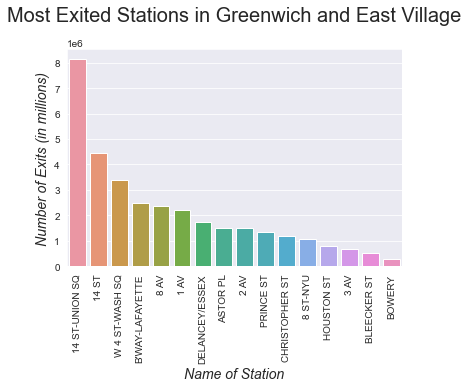

In [121]:
first_viz = sns.barplot(x='STATION', y= 'NEW_ENTRIES', data= station_totals)
plt.xticks(rotation=90)
plt.title('Most Exited Stations in Greenwich and East Village',y=1.1,fontsize=20)
plt.ylabel('Number of Exits (in millions)',fontstyle='oblique',fontsize=14)
plt.xlabel('Name of Station',fontstyle='oblique',fontsize=14)
sns.set_style('darkgrid')
plt.savefig('Most_Exited2.png',bbox_inches='tight')

# Building a Time Series

We see that Union Square has by far the most exits. Now let's create a time series for that station.

In [122]:
#filter data to just include Union Square
union_square = regional_stations[regional_stations['STATION'] == '14 ST-UNION SQ']

In [126]:
# create a standardized list of times to filter the data on
list_of_times = ['00:00:00','04:00:00','08:00:00','12:00:00','16:00:00','20:00:00']

In [127]:
#filter the data with the previous list
union_square = union_square[union_square['TIME'].isin(list_of_times)]

In [128]:
union_square.TIME.value_counts()

12:00:00    4043
08:00:00    4037
04:00:00    4036
16:00:00    4033
00:00:00    4002
20:00:00    3972
Name: TIME, dtype: int64

These times are very close to even so we will move forward with the time series.

In [130]:
#add a day of the week column to the data
union_square['day_of_week'] = union_square['DATETIME'].dt.dayofweek

In [131]:
#create mappings that take each time and change it to how far in the day that is
def create_mappings(value):
    if value == '00:00:00':
        return 0
    elif value == '04:00:00':
        return (1/6)
    elif value == '08:00:00':
        return (1/3)
    elif value == '12:00:00':
        return (1/2)
    elif value == '16:00:00':
        return (2/3)
    elif value == '20:00:00':
        return (5/6)
    else:
        return None

In [132]:
#add an hours column to the data
union_square['Hours'] = union_square['TIME'].apply(create_mappings) 

In [133]:
#combine the hours and day of the week columns to get the final x-axis for the dataset
union_square['TIME_SERIES'] = union_square['Hours'] + union_square['day_of_week']

In [134]:
#get the average number of exits in each timeperiod
union_square_time_series = union_square.groupby(['YEAR','TIME_SERIES'],as_index=False)['NEW_ENTRIES'].mean()

In [135]:
union_square_time_series.head()

,YEAR,TIME_SERIES,NEW_ENTRIES
0,2016,0.000000,104.661871
1,2016,0.166667,26.649007
2,2016,0.333333,203.284768
3,2016,0.500000,656.079470
4,2016,0.666667,490.920530


Split the data into each year so that we can see if the trend is consistent year over year.

In [137]:
union_square_2016 = union_square_time_series[union_square_time_series['YEAR'] == 2016]
union_square_2017 = union_square_time_series[union_square_time_series['YEAR'] == 2017]
union_square_2018 = union_square_time_series[union_square_time_series['YEAR'] == 2018]
union_square_2019 = union_square_time_series[union_square_time_series['YEAR'] == 2019]

# Visualization 2

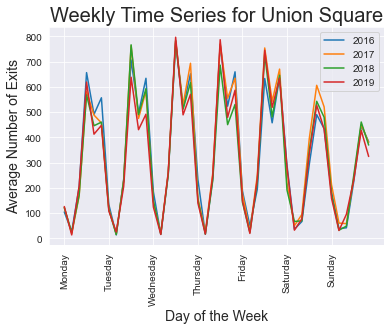

In [148]:
plt.plot(union_square_2016['TIME_SERIES'], union_square_2016['NEW_ENTRIES'],label='2016')
plt.plot(union_square_2017['TIME_SERIES'], union_square_2017['NEW_ENTRIES'],label='2017')
plt.plot(union_square_2018['TIME_SERIES'], union_square_2018['NEW_ENTRIES'],label='2018')
plt.plot(union_square_2019['TIME_SERIES'], union_square_2019['NEW_ENTRIES'],label='2019')
plt.title('Weekly Time Series for Union Square',fontsize=20)
plt.xticks([0,1,2,3,4,5,6],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],rotation=90)
plt.xlabel('Day of the Week',fontsize=14)
plt.ylabel('Average Number of Exits',fontsize=14)
plt.legend()
plt.savefig('Union_Square_Time_Series.png',bbox_inches='tight')